In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#Preprocessing imports
import os
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from PIL import Image
from glob import glob
from shutil import copy2
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import hashlib
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import DatasetFolder
from PIL import Image

In [7]:
!pip install opencv-python

In [8]:
# Data Cleaning: Sahiti

def calculate_hash(image):
    return hashlib.md5(image.tobytes()).hexdigest()

def remove_duplicates(images_folder):
    image_hashes = {}
    image_files = [file for file in os.listdir(images_folder) if file.endswith(('.jpg', '.png', '.jpeg'))]
    for filename in image_files:
        image = cv2.imread(os.path.join(images_folder, filename))

        if image is not None:
            image_hash = calculate_hash(image)
            if image_hash in image_hashes:
                print(f"Duplicate image found: {filename}, removing...")
                os.remove(os.path.join(images_folder, filename))
            else:

                image_hashes[image_hash] = filename
        else:
            print(f"Error loading image: {filename}, removing...")
            os.remove(os.path.join(images_folder, filename))

    print("Duplicate and invalid image removal completed.")

def preprocess_images(images_folder, output_folder):

    os.makedirs(output_folder, exist_ok=True)
    image_files = [file for file in os.listdir(images_folder) if file.endswith(('.jpg', '.png', '.jpeg'))]

    for filename in image_files:

        image = cv2.imread(os.path.join(images_folder, filename))

        if image is not None:

            resized_image = cv2.resize(image, (224, 224))

            normalized_image = resized_image.astype(np.float32) / 255.0

            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, normalized_image * 255)

            print(f"Processed and saved: {output_path}")
        else:
            print(f"Error loading image: {filename}")

    print("Image preprocessing completed.")

input_images_folder = "/content/drive/MyDrive/Team 4 Potato Diseases Datasets"
output_images_folder = "/content/drive/MyDrive/Cleaned_images_()"
remove_duplicates(input_images_folder)
preprocess_images(input_images_folder, output_images_folder)



Duplicate and invalid image removal completed.
Image preprocessing completed.


In [9]:
# Normalization: Jyostna

from sklearn.preprocessing import StandardScaler
import numpy as np
from PIL import Image

def normalize_data(X_train, X_val, X_test, image_size=(64, 64)):
    """
    Normalize the input data using StandardScaler.

    Args:
        X_train (list): Training data.
        X_val (list): Validation data.
        X_test (list): Test data.
        image_size (tuple): Target size for the images (width, height).

    Returns:
        np.ndarray, np.ndarray, np.ndarray: Normalized training, validation, and test data.
    """
    # Create a StandardScaler object
    scaler = StandardScaler()

    # Load, resize, and flatten the images
    X_train_array = np.array([np.array(Image.open(img_path).convert('RGB').resize(image_size)).flatten() for img_path in X_train])
    X_val_array = np.array([np.array(Image.open(img_path).convert('RGB').resize(image_size)).flatten() for img_path in X_val])
    X_test_array = np.array([np.array(Image.open(img_path).convert('RGB').resize(image_size)).flatten() for img_path in X_test])

    # Fit the scaler to the training data and transform the training, validation, and test data
    X_train_normalized = scaler.fit_transform(X_train_array)
    X_val_normalized = scaler.transform(X_val_array)
    X_test_normalized = scaler.transform(X_test_array)

    return X_train_normalized, X_val_normalized, X_test_normalized

In [10]:
# Data Augmentation: Sonal
from PIL import Image
import os
from glob import glob
import albumentations as A
import numpy as np

def resize_and_augment_images(input_path, output_dir, target_size=(200, 200), resample_filter=Image.BILINEAR, augmentation_ops=None, sample_size=1, seed=42):
    if os.path.isfile(input_path):
        process_single_image(input_path, output_dir, target_size, resample_filter, augmentation_ops, sample_size, seed)
    elif os.path.isdir(input_path):
        process_directory(input_path, output_dir, target_size, resample_filter, augmentation_ops, sample_size, seed)
    else:
        print(f"The input path '{input_path}' does not exist.")
        return

def process_single_image(image_path, output_dir, target_size, resample_filter, augmentation_ops, sample_size, seed):
    image = Image.open(image_path)
    resized_image = image.resize(target_size, resample=resample_filter)

    # Apply data augmentation
    if augmentation_ops is not None:
        np.random.seed(seed)
        for _ in range(sample_size):
            augmented_image = augmentation_ops(image=np.array(resized_image))["image"]
            file_name, file_ext = os.path.splitext(os.path.basename(image_path))
            output_path = os.path.join(output_dir, f"{file_name}_{_}{file_ext}")
            Image.fromarray(augmented_image).save(output_path)
    else:
        file_name, file_ext = os.path.splitext(os.path.basename(image_path))
        output_path = os.path.join(output_dir, f"{file_name}{file_ext}")
        resized_image.save(output_path)

    display(resized_image)
    print(f"Image resizing and augmentation complete. {1 + sample_size} images processed.")

def process_directory(input_dir, output_dir, target_size, resample_filter, augmentation_ops, sample_size, seed):
    os.makedirs(output_dir, exist_ok=True)
    image_files = glob(os.path.join(input_dir, '*.jpg')) + glob(os.path.join(input_dir, '*.png'))
    if not image_files:
        print(f"No images found in the input directory: {input_dir}")
        return

    for image_path in image_files:
        process_single_image(image_path, output_dir, target_size, resample_filter, augmentation_ops, sample_size, seed)

# Example usage
input_path = "/content/download2.jpg"
output_dir = "/content/"
target_size = (200, 200)
resample_filter = Image.BILINEAR

# Define data augmentation operations
augmentation_ops = A.Compose([
    A.Rotate(limit=45, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.GaussianBlur(blur_limit=5, p=0.5),
])

resize_and_augment_images(input_path, output_dir, target_size, resample_filter, augmentation_ops, sample_size=5, seed=42)

The input path '/content/download2.jpg' does not exist.


/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/blur/transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


In [11]:
# Data Splitting Script by Sai Kumar

import os
from sklearn.model_selection import train_test_split
from glob import glob
from shutil import copy2
from collections import defaultdict

dataset_dir = '/content/drive/MyDrive/Team 4 Potato Diseases Datasets'

train_dir = '/content/drive/MyDrive/dataset_split/train'
val_dir = '/content/drive/MyDrive/dataset_split/val'
test_dir = '/content/drive/MyDrive/dataset_split/test'


for dir in [train_dir, val_dir, test_dir]:
    os.makedirs(dir, exist_ok=True)


data = defaultdict(list)


for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_dir):
        images = glob(os.path.join(class_dir, '*.jpg'))
        if images:
            data[class_name] = images
        else:
            print(f"No images found for class '{class_name}'. Check the directory or file extensions.")

# Split and copy files
for class_name, images in data.items():
    if images:
        # Initial split: 70% for training and 30% for temp
        X_train, X_temp, y_train, y_temp = train_test_split(images, [class_name] * len(images), test_size=0.3, random_state=42)

        # Splitting the temp set: 50% for validation and 50% for testing, achieving 15% of the total each
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

        # Copying files to respective directories
        for x, dest_dir in [(X_train, train_dir), (X_val, val_dir), (X_test, test_dir)]:
            dest_path = os.path.join(dest_dir, class_name)
            os.makedirs(dest_path, exist_ok=True)
            for img_path in x:
                copy2(img_path, dest_path)
    else:
        print(f"Skipping class '{class_name}' due to no available images.")

print("Data splitting complete.")


No images found for class 'cleaned_images'. Check the directory or file extensions.
Data splitting complete.


In [12]:
# Image Resizing and Resampling: Vamshi

from PIL import Image
import os
from glob import glob
from IPython.display import display

def resize_and_resample_images(input_path, output_dir, target_size=(200,200), resample_filter=Image.BILINEAR):
    if os.path.isfile(input_path):
        process_single_image(input_path, output_dir, target_size, resample_filter)
    elif os.path.isdir(input_path):
        process_directory(input_path, output_dir, target_size, resample_filter)
    else:
        print(f"The input path '{input_path}' does not exist.")
        return

def process_single_image(image_path, output_dir, target_size, resample_filter):
    image = Image.open(image_path)
    resized_image = image.resize(target_size, resample=resample_filter)
    file_name, file_ext = os.path.splitext(os.path.basename(image_path))
    output_path = os.path.join(output_dir, f"{file_name}{file_ext}")
    resized_image.save(output_path)
    display(resized_image)
    print(f"Image resizing and resampling complete. 1 image processed.")

def process_directory(input_dir, output_dir, target_size, resample_filter):
    os.makedirs(output_dir, exist_ok=True)
    image_files = glob(os.path.join(input_dir, '*.jpg')) + glob(os.path.join(input_dir, '*.png'))
    if not image_files:
        print(f"No images found in the input directory: {input_dir}")
        return
    for image_path in image_files:
        process_single_image(image_path, output_dir, target_size, resample_filter)
    print(f"Image resizing and resampling complete. {len(image_files)} images processed.")

# Example usage
input_path = "/content/Protecting-Potato-Crops-Understanding-and-Preventing-Major-Potato-Diseases.jpg"
output_dir = "/content/"
target_size = (200,200)
resample_filter = Image.BILINEAR
resize_and_resample_images(input_path, output_dir, target_size, resample_filter)

The input path '/content/Protecting-Potato-Crops-Understanding-and-Preventing-Major-Potato-Diseases.jpg' does not exist.


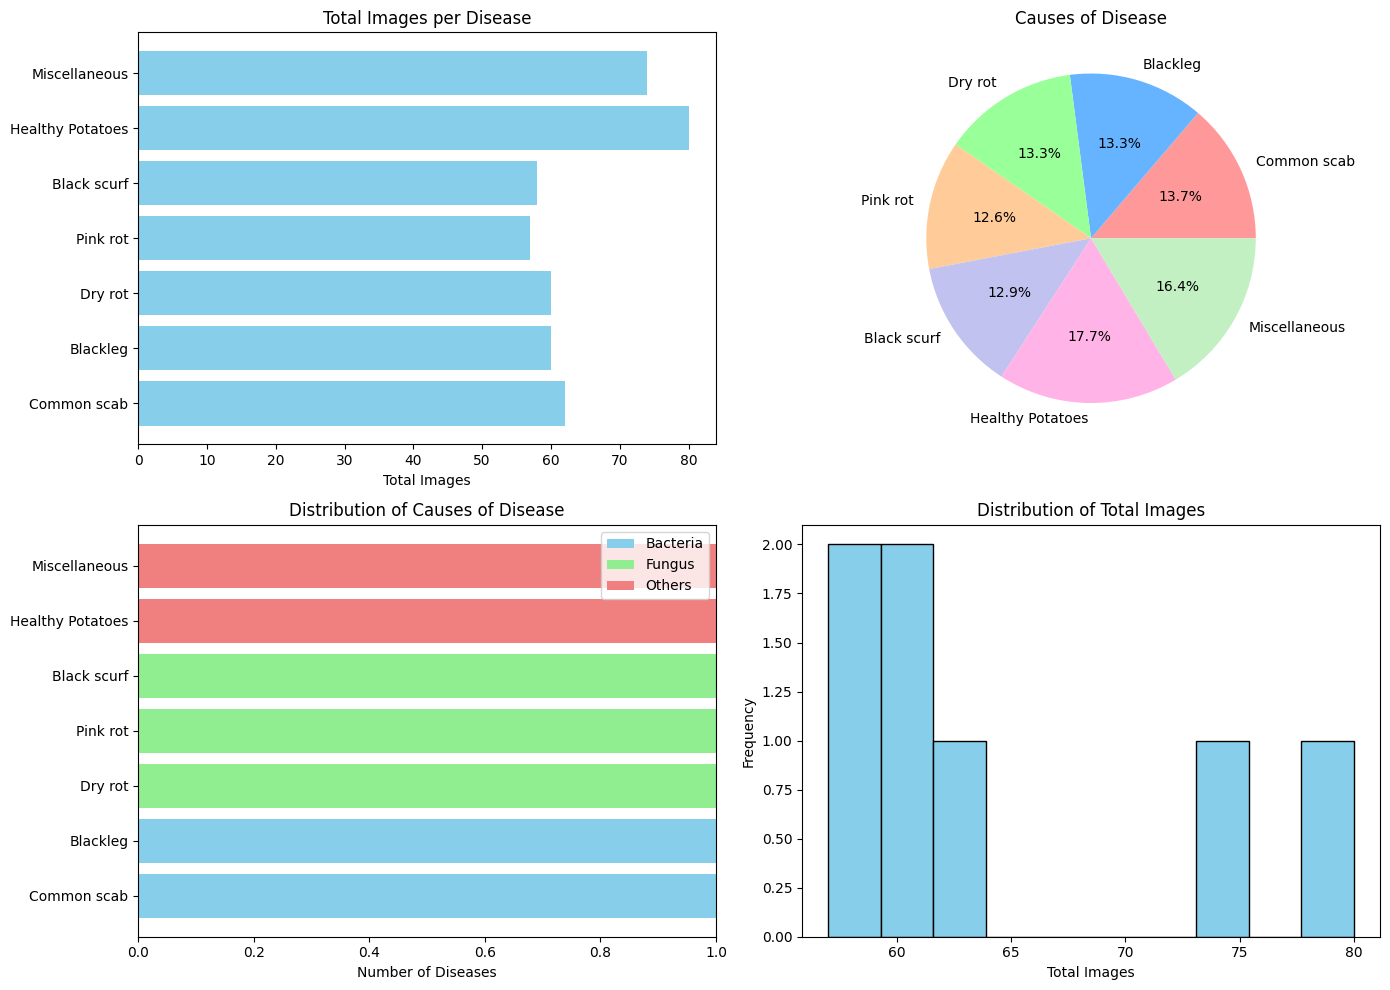

In [13]:
# Visualization: Thrishya

# Disease Information
disease_names = ['Common scab', 'Blackleg', 'Dry rot', 'Pink rot', 'Black scurf', 'Healthy Potatoes', 'Miscellaneous']
total_images = [62, 60, 60, 57, 58, 80, 74]
causes_of_disease = ['Bacteria', 'Bacteria', 'Fungus', 'Fungus', 'Fungus', '-', '-']

# Plotting
plt.figure(figsize=(14, 10))

# Bar plot for total images
plt.subplot(2, 2, 1)
plt.barh(disease_names, total_images, color='skyblue')
plt.xlabel('Total Images')
plt.title('Total Images per Disease')

# Pie chart for causes of disease
plt.subplot(2, 2, 2)
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#c2c2f0', '#ffb3e6', '#c2f0c2']
plt.pie(total_images, labels=disease_names, colors=colors, autopct='%1.1f%%')
plt.title('Causes of Disease')

# Stacked bar plot for causes of disease
plt.subplot(2, 2, 3)
bacteria = [1 if cause == 'Bacteria' else 0 for cause in causes_of_disease]
fungus = [1 if cause == 'Fungus' else 0 for cause in causes_of_disease]
others = [1 if cause not in ['Bacteria', 'Fungus'] else 0 for cause in causes_of_disease]

plt.barh(disease_names, bacteria, color='skyblue', label='Bacteria')
plt.barh(disease_names, fungus, color='lightgreen', left=bacteria, label='Fungus')
plt.barh(disease_names, others, color='lightcoral', left=[b + f for b, f in zip(bacteria, fungus)], label='Others')
plt.xlabel('Number of Diseases')
plt.title('Distribution of Causes of Disease')
plt.legend()

# Histogram for total images
plt.subplot(2, 2, 4)
plt.hist(total_images, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Total Images')
plt.ylabel('Frequency')
plt.title('Distribution of Total Images')

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


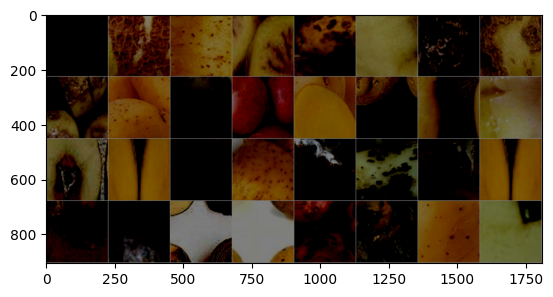

Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


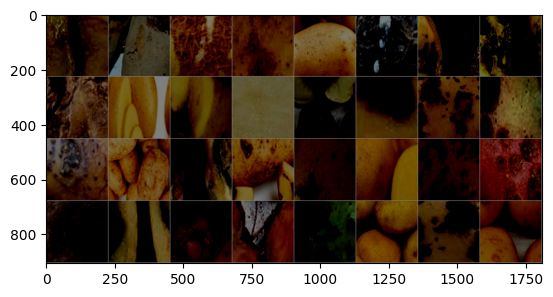

Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


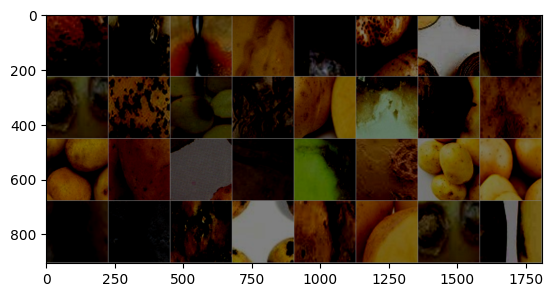

Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


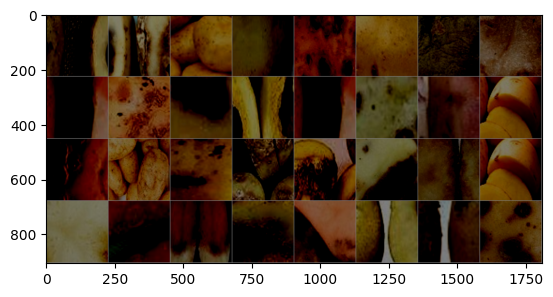

Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


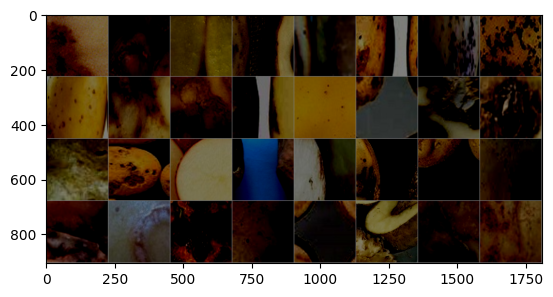

Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


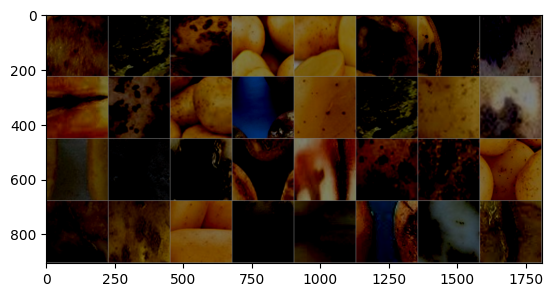

Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


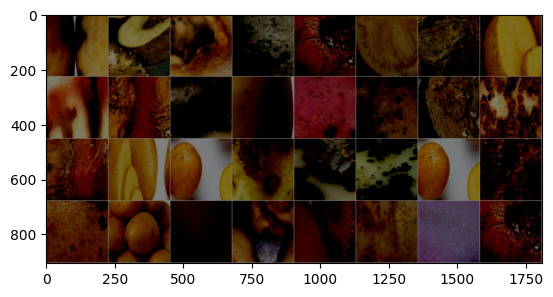

Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


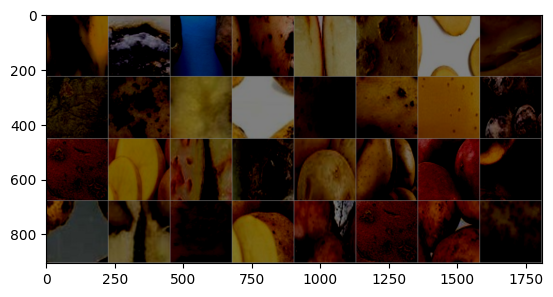

Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


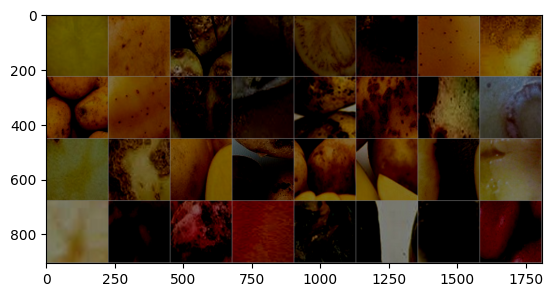

Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


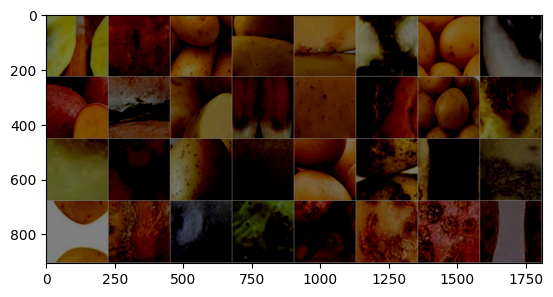

Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


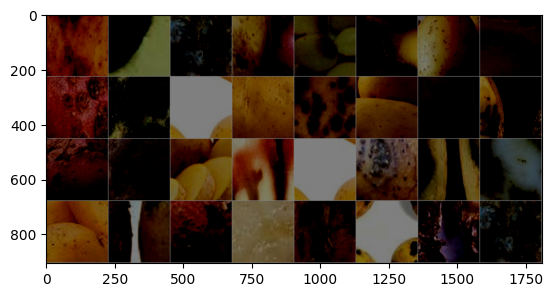

Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


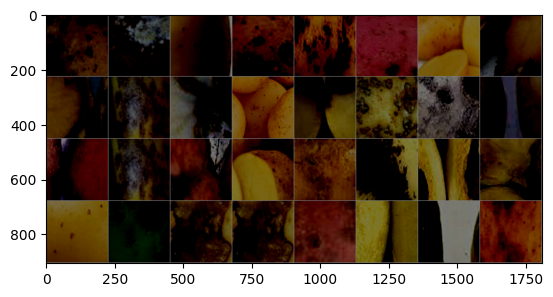

Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


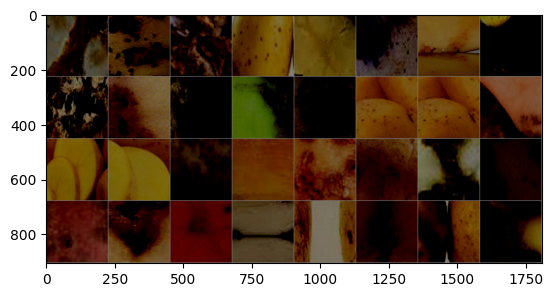

Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


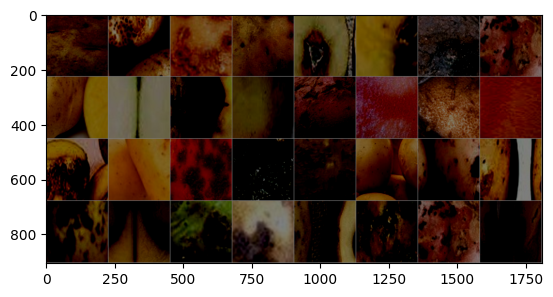

Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


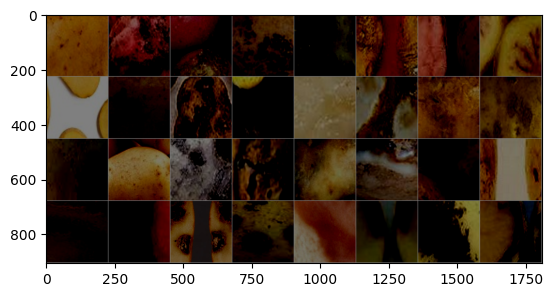

Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


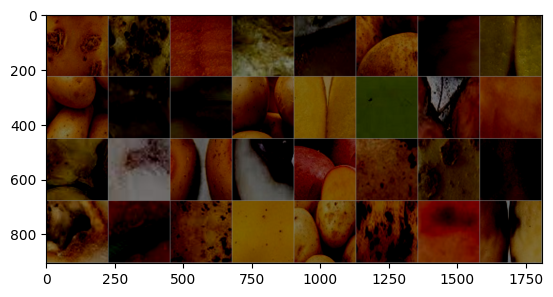

Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


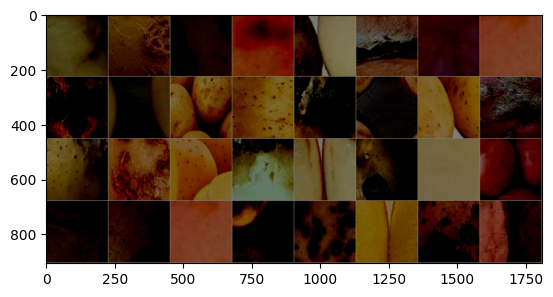

Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


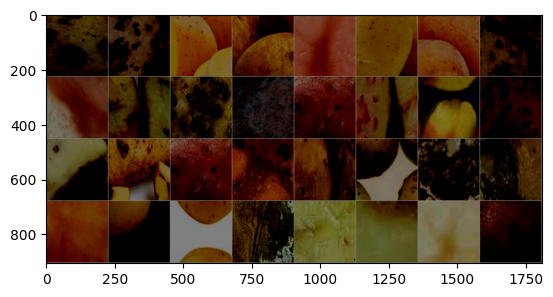

Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


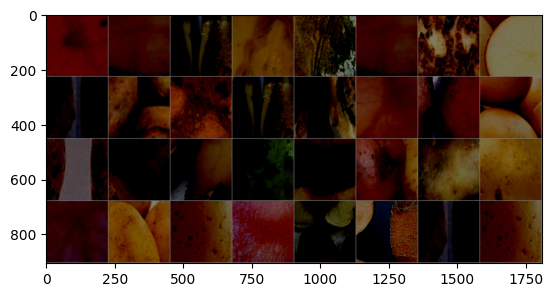

Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


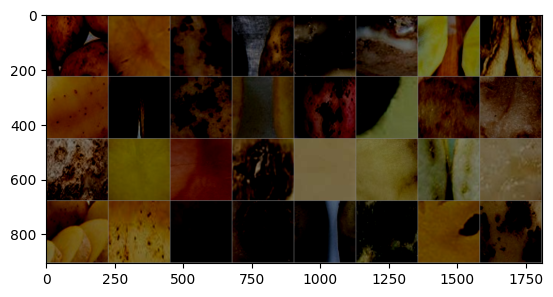

Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


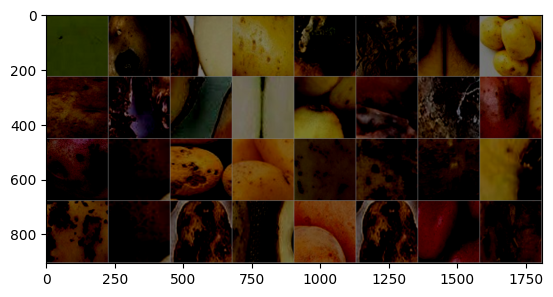

Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


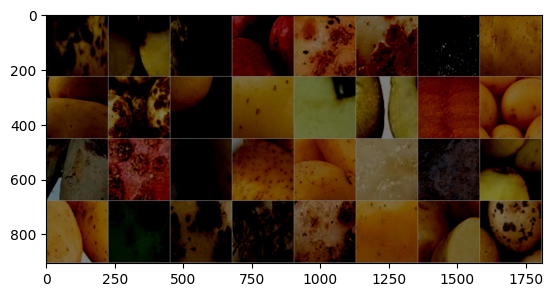

Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


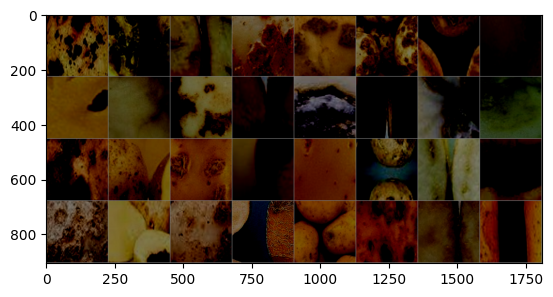

Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


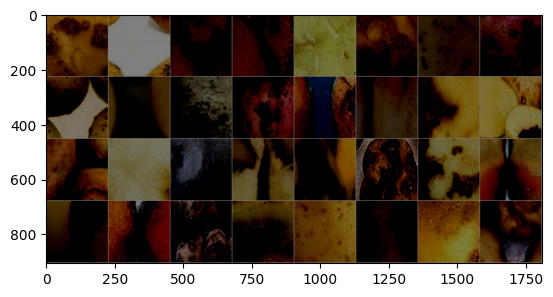

Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


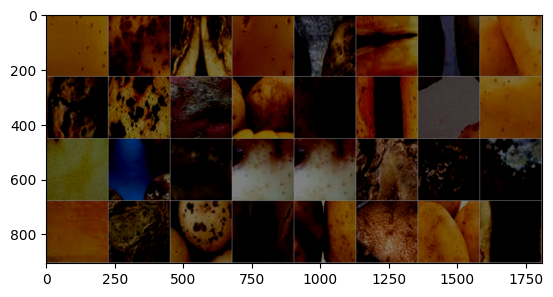

Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


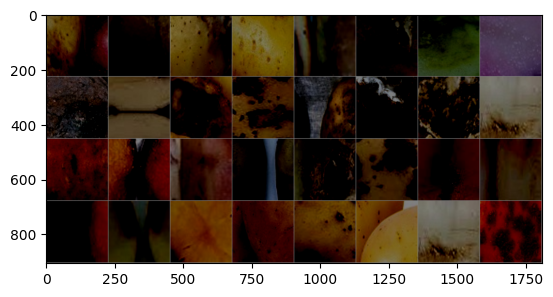

Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


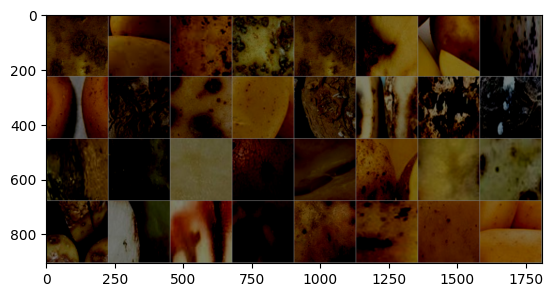

Batch size: 32
Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


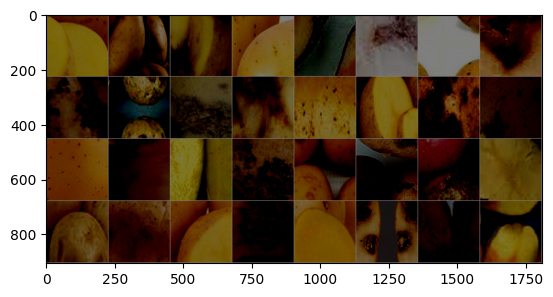

Batch size: 6
Image shape: torch.Size([6, 3, 224, 224])
Label shape: torch.Size([6])


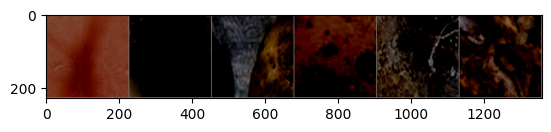

In [14]:
# Dataloader: Keerthana
import os
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import DatasetFolder

root_folder = "/content/drive/MyDrive/Team 4 Potato Diseases Datasets"
valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

transform = transforms.Compose([
    transforms.Resize(768),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[1.0, 1.0, 1.0], std=[0.5, 0.5, 0.5])
])

class CustomDatasetFolder(DatasetFolder):
    def __init__(self, root, transform=None, target_transform=None):
        super().__init__(root=root, loader=self.loader, extensions=valid_extensions, transform=transform, target_transform=target_transform)

    def loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def find_classes(self, directory):
        classes = [d.name for d in os.scandir(directory) if d.is_dir() and d.name != '.ipynb_checkpoints']
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

dataset = CustomDatasetFolder(root=root_folder, transform=transform)

batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

import matplotlib.pyplot as plt
import torchvision

def imshow(img):

    img = img * 0.5 + 0.5
    img = img.permute(1, 2, 0)
    img = img.clamp(0, 1)
    plt.imshow(img)
    plt.show()

for images, labels in data_loader:
    print(f"Batch size: {len(images)}")
    print(f"Image shape: {images.shape}")
    print(f"Label shape: {labels.shape}")
    imshow(torchvision.utils.make_grid(images))
